Machine Failure Prediction using Sensor Data

Author: Yi Luo
Date: 2025-04-12
Dataset: Kaggle - Machine Failure Prediction using Sensor Data

📘 Portfolio Introduction

This project explores machine failure prediction using a labeled dataset of sensor readings collected from industrial equipment. The goal is to build a data-driven model that can detect potential failures based on sensor signals, helping enable predictive maintenance.

The dataset includes 944 records with 9 sensor features (e.g., air quality, VOC, ultrasonic sensor readings) and a binary target variable fail indicating whether a machine failure occurred.

🔍 What We Did:

Data Inspection & Cleaning:
We confirmed there were no missing values. Some features (like footfall) showed extreme variance, so we applied standard scaling to normalize feature ranges.

Exploratory Data Analysis (EDA):

Compared feature distributions between failure and non-failure states using density plots.
Visualized correlations between features with a heatmap.
Computed and ranked correlations with the failure variable to identify impactful features.
Modeling with Random Forest:

Built a Random Forest classifier to predict machine failures.
Applied GridSearchCV to tune hyperparameters and select the best model.
Evaluated performance using accuracy and classification metrics.
Feature Importance:

Visualized which sensor readings most influenced the model.
Found that VOC, Air Quality (AQ), and Ultrasonic Sensor (USS) were the top contributing features in predicting failures.
✅ Key Findings:

The dataset is relatively balanced, making it suitable for classification.
Several sensor features—especially VOC, AQ, and USS—show clear differences between failed and non-failed equipment.
Random Forest delivered strong predictive performance with interpretable results.
These results can guide further research or deployment in real-world predictive maintenance systems.
This project showcases a complete data science pipeline for sensor-based fault detection and serves as a strong portfolio example in applied machine learning.

In [1]:
# === SECTION 1: Imports and Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


# Visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# General settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")


In [2]:
# === SECTION 2: Load and Inspect Data ===

# Load the dataset
data = pd.read_csv("/Users/luoyi/Desktop/10_kaggle/13_Machine_Failure/data.csv") 

# Preview first few rows
display(data.head())

# Overview of dataset: types, nulls, basic stats
print("\n🧾 Basic Info:")
print(data.info())

print("\n📏 Statistical Summary:")
display(data.describe())

print("\n📐 Shape of Data (rows, columns):", data.shape)

# Check for missing values
print("\n❓ Missing Values:")
print(data.isnull().sum())


,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0



🧾 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB
None

📏 Statistical Summary:


,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,306.381356,3.727754,4.325212,2.939619,5.394068,2.842161,47.043432,4.565678,16.331568,0.416314
std,1082.606745,2.677235,1.438436,1.383725,1.269349,2.273337,16.423130,1.599287,5.974781,0.493208
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,14.000000,0.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000,0.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000,1.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000,1.000000



📐 Shape of Data (rows, columns): (944, 10)

❓ Missing Values:
footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64


⚠️ Failure Class Distribution:
fail
0    0.583686
1    0.416314
Name: proportion, dtype: float64


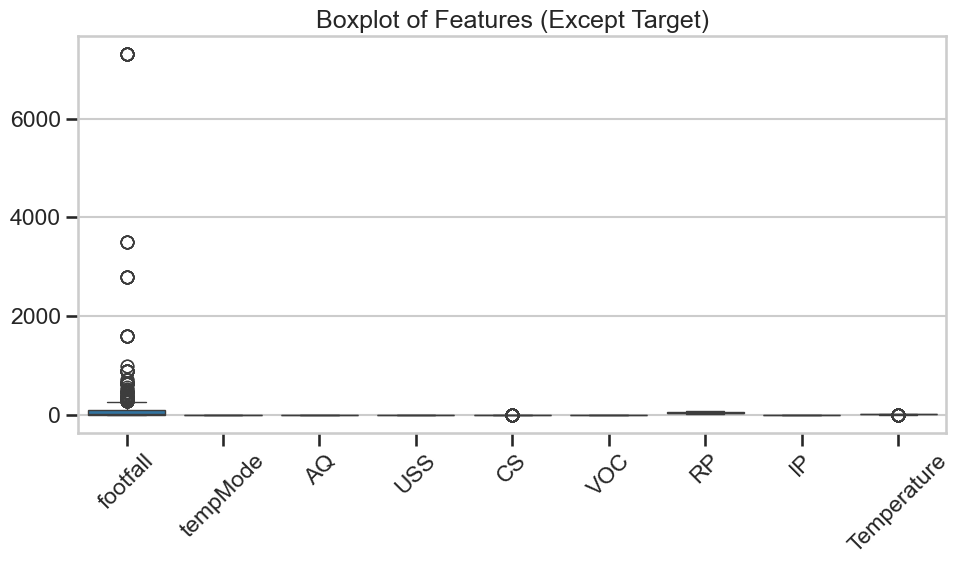

✅ Data scaling complete. Ready for EDA and modeling.


In [3]:
# === SECTION 3: Clean & Preprocess Data ===

# Step 1: Check class balance
print("⚠️ Failure Class Distribution:")
print(data['fail'].value_counts(normalize=True))  # normalized=True 显示比例

# Step 2: Check for extreme outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data.drop(columns='fail'))
plt.title("Boxplot of Features (Except Target)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Scale features (optional, for modeling later)
features = data.drop(columns="fail")
target = data["fail"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to DataFrame for later steps
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
processed_data = pd.concat([features_scaled_df, target], axis=1)

print("✅ Data scaling complete. Ready for EDA and modeling.")


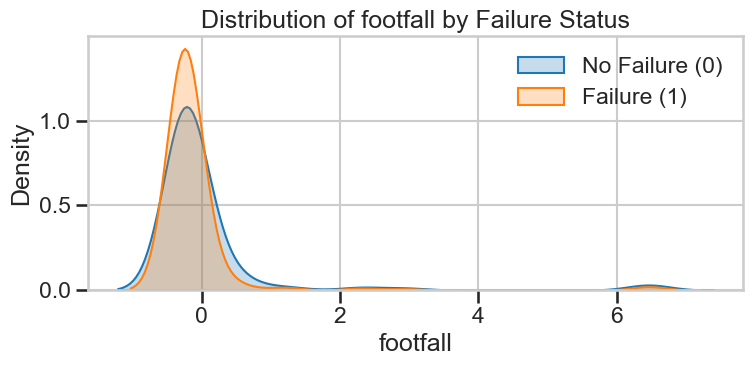

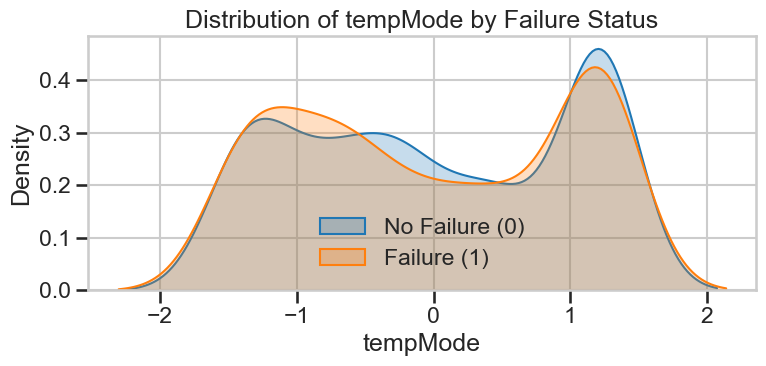

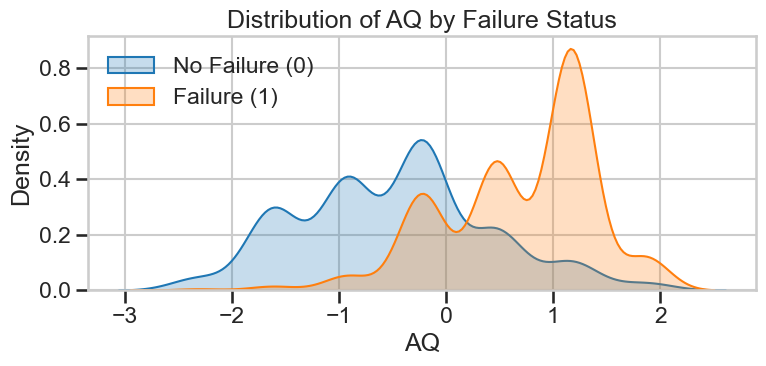

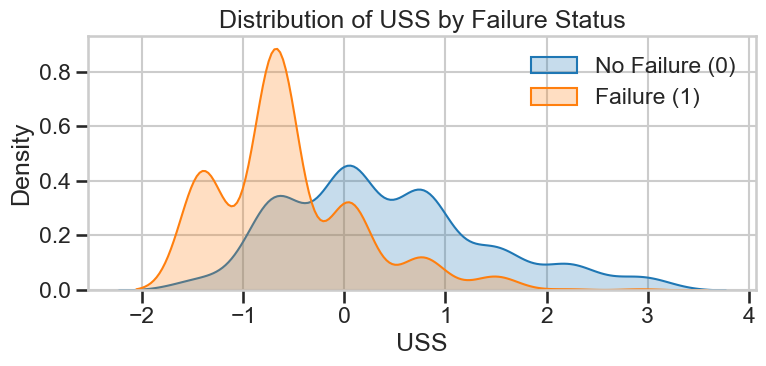

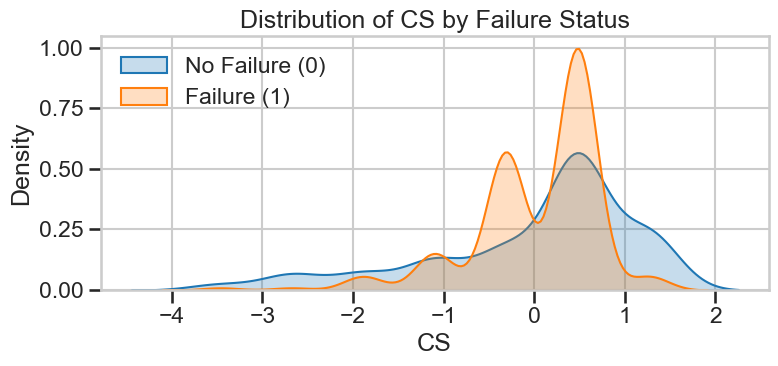

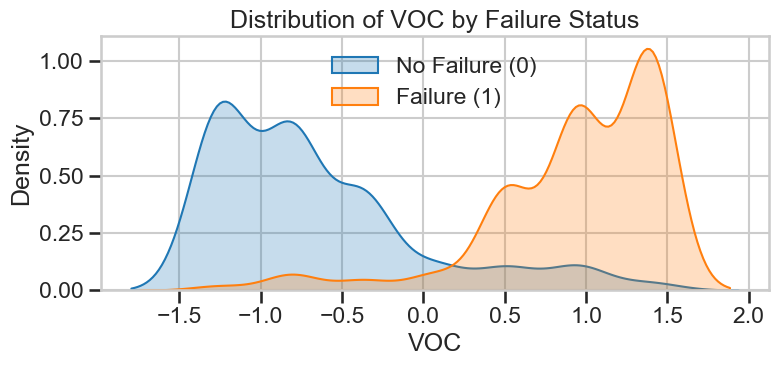

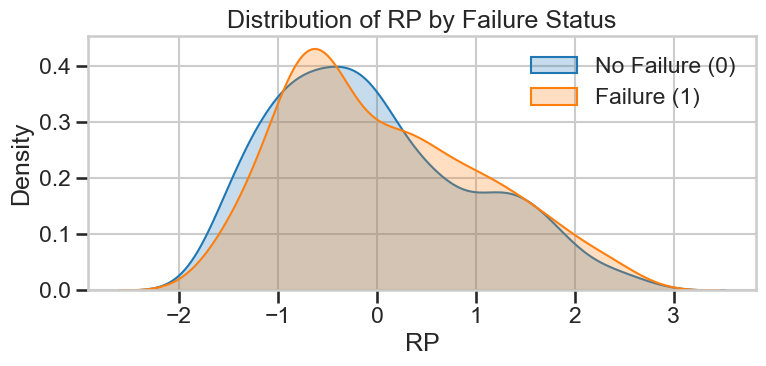

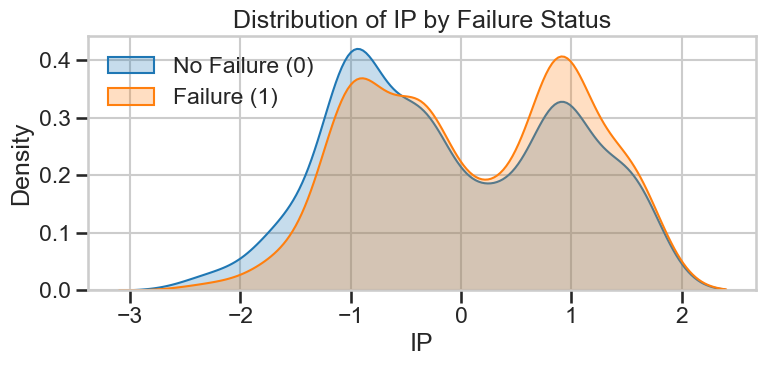

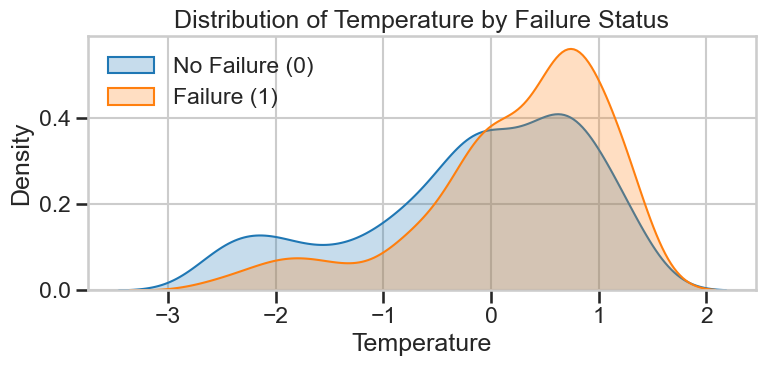

In [4]:
# === SECTION 4: Exploratory Data Analysis (EDA) ===

# Separate failure vs non-failure data
fail_1 = processed_data[processed_data['fail'] == 1]
fail_0 = processed_data[processed_data['fail'] == 0]

# Step 1: Plot histogram for each feature split by fail status
for col in processed_data.columns[:-1]:  # skip 'fail'
    plt.figure(figsize=(8, 4))
    sns.kdeplot(fail_0[col], label='No Failure (0)', shade=True)
    sns.kdeplot(fail_1[col], label='Failure (1)', shade=True)
    plt.title(f"Distribution of {col} by Failure Status")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


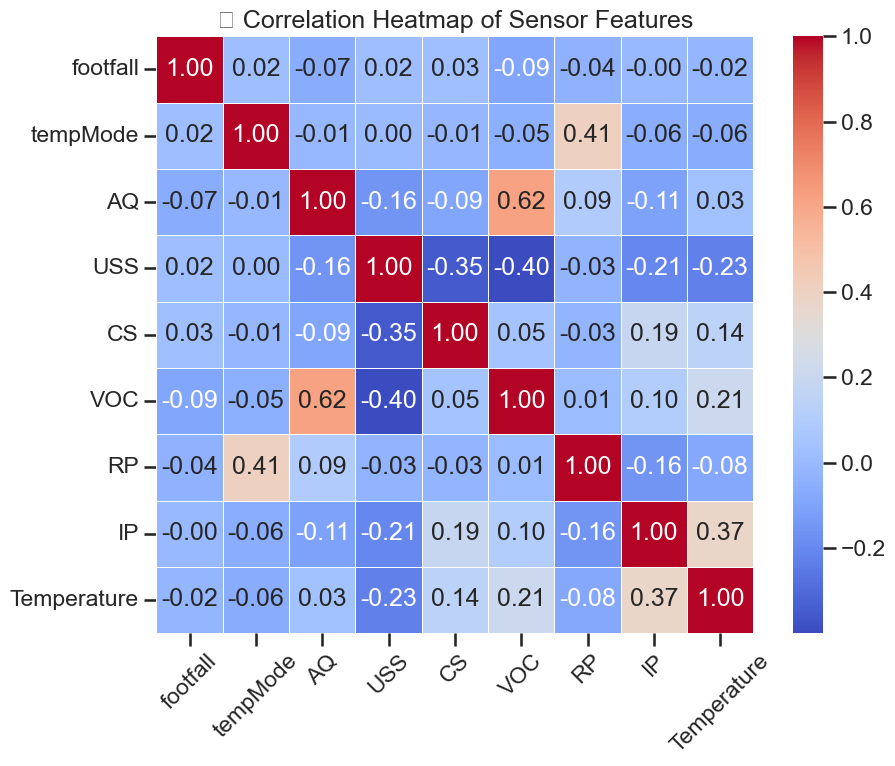

In [5]:
# === SECTION 4.2: Correlation Matrix and Heatmap ===

# Compute correlation matrix (exclude target for now)
corr_matrix = processed_data.drop(columns="fail").corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("🔗 Correlation Heatmap of Sensor Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


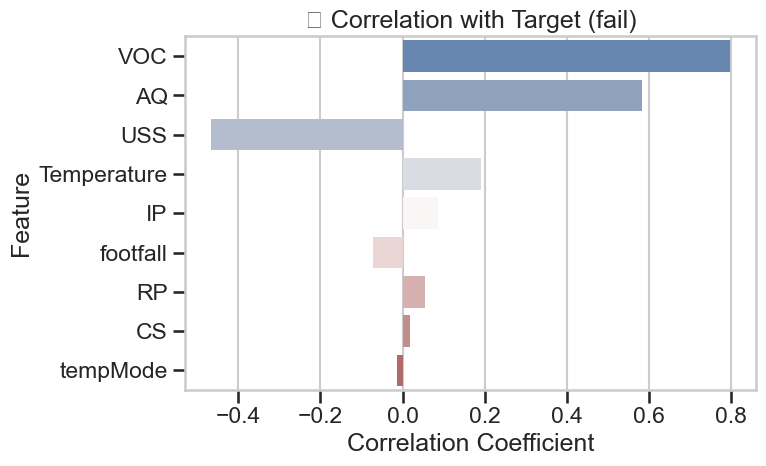

In [6]:
# === SECTION 4.3: Feature vs. Target Correlation (Bar Plot) ===

# Compute correlation between each feature and the target 'fail'
target_corr = processed_data.corr()['fail'].drop('fail').sort_values(key=abs, ascending=False)

# Plot as bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="vlag")
plt.title("📊 Correlation with Target (fail)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


🎯 Accuracy: 0.9259259259259259

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       110
           1       0.90      0.92      0.91        79

    accuracy                           0.93       189
   macro avg       0.92      0.93      0.92       189
weighted avg       0.93      0.93      0.93       189



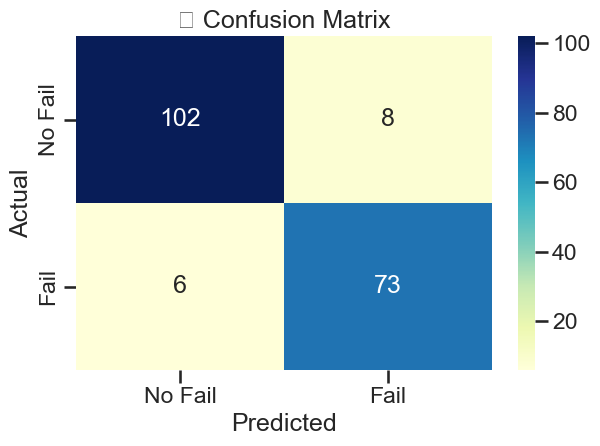

In [7]:
# === SECTION 5: Random Forest Modeling ===

# Step 1: Train/test split
X = processed_data.drop(columns="fail")
y = processed_data["fail"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Initialize and fit the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = rf.predict(X_test)

# Step 4: Evaluate performance
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🧾 Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu", xticklabels=["No Fail", "Fail"], yticklabels=["No Fail", "Fail"])
plt.title("🧪 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [8]:
# === SECTION 6.1: Grid Search for Random Forest ===

from sklearn.model_selection import GridSearchCV

# Set up parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("✅ Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


🎯 Best Model Accuracy: 0.9153439153439153

🧾 Classification Report (Best RF):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       110
           1       0.89      0.91      0.90        79

    accuracy                           0.92       189
   macro avg       0.91      0.91      0.91       189
weighted avg       0.92      0.92      0.92       189



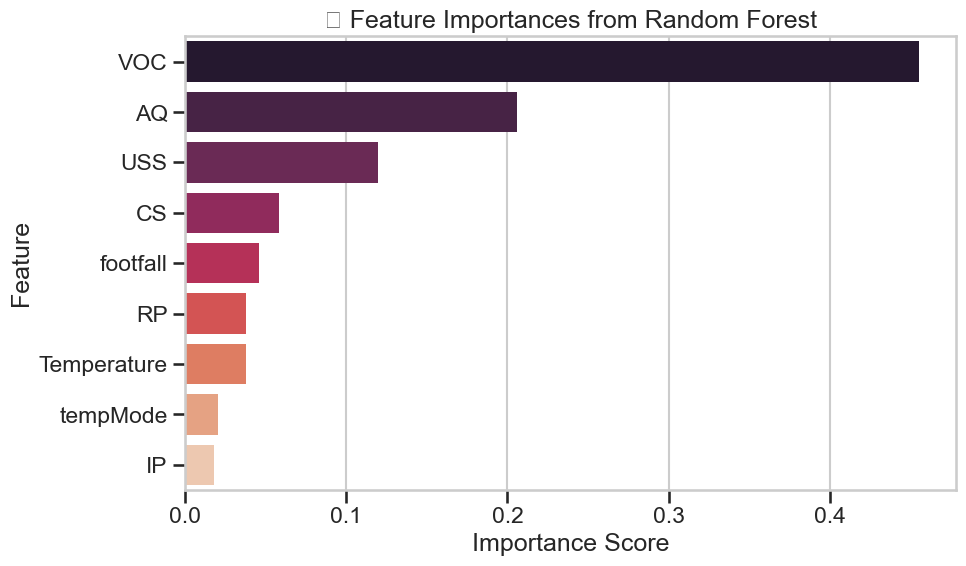

In [9]:
# Predict again using the best model
y_pred_best = best_rf.predict(X_test)

# Evaluate
print("🎯 Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("\n🧾 Classification Report (Best RF):")
print(classification_report(y_test, y_pred_best))

# === Plot Feature Importances ===
importances = best_rf.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="rocket")
plt.title("🌟 Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
